# LSTM-TrajGAN [1]

The original implementation can be found at: https://github.com/GeoDS/LSTM-TrajGAN/

[1] Rao, J., Gao, S.*, Kang, Y. and Huang, Q. (2020). LSTM-TrajGAN: A Deep Learning Approach to Trajectory Privacy Protection. In the Proceedings of the 11th International Conference on Geographic Information Science (GIScience 2021), 12:1--12:17.

In [1]:
%load_ext autoreload
%autoreload 2
import os

    
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    # Move to default colab folder
    %cd /content
    # Check if repository is already cloned
    if not os.path.isdir("stg"):
        # Clone repository
        !git clone --recursive https://github.com/erik-buchholz/SoK-TrajGen.git stg
    # Change to repository directory
    %cd stg
    # Only install requirements not already installed by Colab
    !pip install opacus haversine utm
    # SLOW: Only execute the following line if you encounter an error regarding a package not being installed
    # !pip install -r requirements.txt
else:
    import sys
    sys.path.append('..')  # Required for finding the `stg` module

In [2]:
import os
import logging
import random

import pandas as pd
import numpy as np
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from stg.datasets.padding import pad_feature_first

from stg import config
from stg.utils.helpers import get_ref_point, get_scaling_factor
from stg.utils.logger import configure_root_loger
from stg.utils import helpers, visualise
from stg.datasets.base_dataset import DatasetModes
# Load PyTorch Dataset
from stg.datasets.fs_nyc import FSNYCDataset, PATH_ALL
from stg.metrics import compute_list_differences as count_diff_in_list


configure_root_loger(logging_level=logging.INFO)

<RootLogger root (INFO)>

In [3]:
# Define GPU to use
GPU = 0

# Allocates a lot of GPU memory. Should only be used to validate the model.
USE_TF = False 

## Constants

In the following we will use mostly the same (hyper)parameters as the original implementation.
According to the authors [1] the original evaluation was performed with the following parameters:

> We train the LSTM-TrajGAN model on the training set for 2,000 epochs with several default training hyperparameters (e.g., we use an adam optimizer with a learning rate of 0.001 and set the batch size to 256).

- Dataset: Foursquare NYC
- ~Epochs: 2000~
    - Note: The authors define an epoch as one batch instead of one pass over the entire dataset. The Foursquare NYC dataset contains 2052 trajectories. With a batch size of 256, one epoch is equivalent to 8 batches. Therefore, we will train for 2000 / 8 = **250 epochs**.
- Batch Size: 256
- Learning Rate: 0.001
- Beta: 0.5
- Latent Dimension: 100  (Note, this refers to the size of the input noise and not the latent dimension of the LSTM)
- Max. Length: 144

In [4]:
# Constants according to original implementation
max_len = 144
latent_dim = 100
batch_size = 256
epochs = 250
lr = 0.001
beta = 0.5
name = 'LSTM-TrajGAN'

## TensorFlow Model

The original implementation of LSTM-TrajGAN by the authors can be found at: [https://github.com/GeoDS/LSTM-TrajGAN/](https://github.com/GeoDS/LSTM-TrajGAN/).
This implementation is based on TensorFlow 1.13.1. 
In order to make the implementation work in this project, the code was adapted to TensorFlow 2.
The corresponding code can be found in the files `stg/ml_tf/lstm_trajgan.py`, and `stg/ml_tf/loss.py`.
We will not be using this TensorFlow model for our evaluations as we encountered performance issues running TensorFlow on our server.
Therefore, we re-implemented LSTM-TrajGAN in PyTorch.
However, we aim to show that the TensorFlow implementation is equivalent to the PyTorch implementation in the following.

In [5]:
if USE_TF:
    # Define GPU to use
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPU}"
    
    from stg.ml_tf.lstm_trajgan import LSTM_TrajGAN, to_trajGAN_input
    
    # Load training data
    path = config.BASE_DIR + 'data/fs_nyc/train_latlon.csv'
    ts: pd.DataFrame = pd.read_csv(path, dtype={'tid': str, 'label': 'int32'})
    
    # Determine Reference point
    ref = get_ref_point(ts[['lat', 'lon']])
    sf = get_scaling_factor(ts[['lat', 'lon']], ref)
    
    trainX = to_trajGAN_input(ts, ref, 10)
    print(f"Reference Point:\t{ref}")
    print(f"Scale Factor:\t{sf}")

In [6]:
if USE_TF:
    # Create model
    # noinspection PyUnboundLocalVariable
    tf_gan = LSTM_TrajGAN(
        reference_point=ref,
        scale_factor=sf,
        max_length=max_len,
        latent_dim=latent_dim,
        model_name=name,
        learning_rate=lr,
        beta=beta,
    )
else:
    tf_gan = None

In [7]:
# Training does not work in Notebook, use CMD instead
# 
# tf_gan.train(trainX,
#           epochs=epochs,
#           save_freq=10,
#           batch_size=batch_size,
#           print_training=True
#           )

In [8]:
if USE_TF:
    # Print model summary
    print("#" * 80)
    print("Generator:")
    print("#" * 80)
    print(tf_gan.generator.summary())
    print("#" * 80)
    print(tf_gan.discriminator.summary())
    print("#" * 80)
    print("Combined:")
    print(tf_gan.combined.summary())

### Parameter Counts
- Generator: 106,301
- Discriminator: 92,059
- Combined: 198,360

## PyTorch Model

To make LSTM-TrajGAN comparable to the other considered models in this project, we re-implemented the model in PyTorch.
The corresponding code can be found in the files `stg/ml_torch/lstm_trajgan.py`, and `stg/ml_torch/loss.py`.
We tried to keep the PyTorch implementation as close to the original TensorFlow implementation as possible.
You can find unittests comparing the model parameters in the file `test/test_lstmtrajgan.py`.
The trajLoss implementation was tested in the file `test/test_loss.py`.

Please note that the PyTorch implementation uses a different implementation of the LSTM layer.
The PyTorch LSTM layer has an additional bias term which results in an additional 400 parameters.

### Load Dataset

In [9]:
spatial_columns = ['lon', 'lat']

# Compute reference point and scaling factor basd on all data
# Note that this is a privacy leakage in some sense, however, the original implementation does it this way, and we intend to stay as close as possible to the original implementation.
# In theory, it would be preferable to compute the reference point and scaling factor based on the insensitive data only. 
_all = pd.read_csv(PATH_ALL)
ref = helpers.get_ref_point(_all[spatial_columns])
sf = helpers.get_scaling_factor(_all[spatial_columns], ref)

train_dataset = FSNYCDataset(
    mode=DatasetModes.TRAIN,
    spatial_columns=spatial_columns,
    latlon_only=False,
    normalize=True,
    return_labels=False,
    reference_point=ref,
    scale_factor=sf,
)

print("Training Samples:\t", len(train_dataset))
# print("All Samples:\t\t", len(all_dataset))
print("Reference Point:\t", ref)
print("Scaling Factor:\t\t", sf)
print("Features:\t\t\t", train_dataset.features)

# Expected Output:
# Reference Point:	 [-73.977705979516, 40.76959209333479]
# Scaling Factor:    [0.29193802048399675, 0.21873962593050322]

[2024-02-05 11:24:43,842][INFO   ] Reading trajectories from '/home/erik/project2/data/fs_nyc/train_latlon.csv'. (fs_nyc.py:85) 
Training Samples:	 2052
Reference Point:	 [-73.97770598  40.76959209]
Scaling Factor:		 [0.29193802 0.21873963]
Features:			 ['latlon', 'hour', 'day', 'category']


In [10]:
from stg.models.lstm_trajgan import LSTM_TrajGAN as LSTM_TrajGAN_PyTorch

torch_gan = LSTM_TrajGAN_PyTorch(
    reference_point=ref,
    scale_factor=sf,
    gpu=0 if USE_TF else GPU, # Have to use 0 in case of TF usage because the device is set up via environment variable for TF,
    learning_rate=lr,
    beta=beta,
)

In [11]:
from stg.utils.helpers import count_parameters_torch

# Print model summary
print("#" * 80, "\n", "Total Parameters of Generator:\t\t", count_parameters_torch(torch_gan.gen))
print("#" * 80)
print("#" * 80, "\n", "Total Parameters of Discriminator:\t", count_parameters_torch(torch_gan.dis))
print("#" * 80)

[2024-02-05 11:24:48,980][INFO   ] embedding_layers.latlon: 192 (helpers.py:56) 
[2024-02-05 11:24:48,981][INFO   ] embedding_layers.hour: 600 (helpers.py:56) 
[2024-02-05 11:24:48,983][INFO   ] embedding_layers.day: 56 (helpers.py:56) 
[2024-02-05 11:24:48,984][INFO   ] embedding_layers.category: 110 (helpers.py:56) 
[2024-02-05 11:24:48,985][INFO   ] feature_fusion.0: 20600 (helpers.py:56) 
[2024-02-05 11:24:48,986][INFO   ] lstm.weight_ih_l0: 40000 (helpers.py:56) 
[2024-02-05 11:24:48,987][INFO   ] lstm.weight_hh_l0: 40000 (helpers.py:56) 
[2024-02-05 11:24:48,988][INFO   ] lstm.bias_ih_l0: 400 (helpers.py:56) 
[2024-02-05 11:24:48,989][INFO   ] lstm.bias_hh_l0: 400 (helpers.py:56) 
[2024-02-05 11:24:48,990][INFO   ] output_layers.latlon: 202 (helpers.py:56) 
[2024-02-05 11:24:48,991][INFO   ] output_layers.hour: 2424 (helpers.py:56) 
[2024-02-05 11:24:48,992][INFO   ] output_layers.day: 707 (helpers.py:56) 
[2024-02-05 11:24:48,993][INFO   ] output_layers.category: 1010 (helpers.p

### Parameter Counts
- Generator: 106,701 (+400)
- Discriminator: 92,459 (+400)

Both counts are 400 parameters higher than the equivalent TensorFlow model.
This is due to the fact that the PyTorch model uses a different implementation of the LSTM layer with an additional bias term.

While the number of parameters does not prove equivalence, it is a good indicator to show the similarity of both models.
Moreover, the file `test/test_loss.py` contains unittests to ensure that the loss functions are equivalent.
The file `test/test_lstmtrajgan.py` contains further similarity tests.

### Training

Create data loader equivalent to the TensorFlow version (i.e., using pre-padding with zeros)
The default in PyTorch is post-padding with zeros
However, [1] states: 
> "Specifically, we use *zero pre-padding* to pad empty trajectory points (i.e., the points whose attributes are all set to zero) to each trajectory until all the trajectories reached the same length as the longest trajectory in the dataset."

In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=pad_feature_first
)
print("Number of Batches per epoch:\t", len(train_loader))
print("Number of Epochs:\t\t\t\t", epochs)
print("Total Number of Batches:\t\t", len(train_loader) * epochs)

Number of Batches per epoch:	 8
Number of Epochs:				 250
Total Number of Batches:		 2000


In [13]:
TRAIN = False  # Load instead of training
LOAD_EPOCH = 250  # Epoch to load
epochs = 1000


if TRAIN:
    # Training
    start = timer()
    torch_gan.training_loop(
        train_loader,
        epochs=epochs,
        save_freq=50,
        print_training=True,
        notebook=True,
    )
    print(f"Training took:\t\t{timer() - start:.2f}s")
else:
    # Load pretrained model
    torch_gan.load_parameters(
        epoch=LOAD_EPOCH,
    )

[2024-02-05 11:24:49,112][INFO   ] Loaded parameters from /home/erik/project2/parameters/LSTM_TrajGAN_PT/0250_COM.pth (trajGAN.py:83) 


### Testing

In [14]:
# Load Test Dataset
test_dataset = FSNYCDataset(
    mode=DatasetModes.TEST,
    latlon_only=False,
    normalize=True,
    return_labels=False,
    keep_original=True,
    reference_point=torch_gan.reference_point,
    scale_factor=torch_gan.scale_factor,
)

[2024-02-05 11:24:49,157][INFO   ] Reading trajectories from '/home/erik/project2/data/fs_nyc/test_latlon.csv'. (fs_nyc.py:85) 


### Evaluate

Evaluation makes mainly sense to compare different hyperparameters, as the loss does not have any meaning by itself

In [15]:
# Evaluate
torch_gan.evaluate(test_dataset, batch_size=batch_size)

5102.827752777781

## Predict and Compare

In the following, we will use a model trained for 250 epochs, as used for the original evaluation, and compare the results.

In [16]:
from stg.models.lstm_trajgan import LSTM_TrajGAN as LSTM_TrajGAN_PyTorch

LOAD_EPOCHS = 250

torch_gan = LSTM_TrajGAN_PyTorch(
    reference_point=ref,
    scale_factor=sf,
    gpu=0 if USE_TF else GPU, # Have to use 0 in case of TF usage because the device is set up via environment variable for TF,
    learning_rate=lr,
    beta=beta,
)
# Load pretrained model at 250 epochs
torch_gan.load_parameters(
    epoch=LOAD_EPOCHS,
)

[2024-02-05 11:24:50,305][INFO   ] Loaded parameters from /home/erik/project2/parameters/LSTM_TrajGAN_PT/0250_COM.pth (trajGAN.py:83) 


In [17]:
predicted_df = torch_gan.predict_and_convert(test_dataset, batch_size=batch_size)
predicted = helpers.df2trajectory_dict(predicted_df, 'tid')

### Visualize Random Example

First, we look at one randomly chosen trajectory.

In [18]:
# Visualize results
# Compute dataset's bounding box based on reference point and scaling factor
reference_point = test_dataset.reference_point
scaling_factor = test_dataset.scale_factor
print("Reference Point:\t", reference_point)
print("Scaling Factor:\t\t", scaling_factor)
bbox = (
    reference_point[0] - scaling_factor[0],
    reference_point[0] + scaling_factor[0],
    reference_point[1] - scaling_factor[1],
    reference_point[1] + scaling_factor[1],
)
print("Bounding Box:\t\t", bbox)

Reference Point:	 [-73.977705979516, 40.76959209333479]
Scaling Factor:		 [0.29193802048399675, 0.21873962593050322]
Bounding Box:		 (-74.269644, -73.685767959032, 40.55085246740429, 40.9883317192653)


Trajectory ID:		21050
Total Points:      	23
Haversine Distance:	459.40 m
Euclidean Distance:	0.02
hour:              	00 /  23 (0%)
day:               	00 /  23 (0%)
category:          	00 /  23 (0%)
################################################################################
       lat_o      lon_o      lat_p      lon_p   abs (m)  haversine (m)
0  40.831283 -73.941393  40.832316 -73.938978  0.002626     233.369002
1  40.770792 -73.985925  40.779716 -73.995308  0.012950    1268.510681
2  40.770853 -73.984865  40.767104 -73.981976  0.004733     482.712222
3  40.770792 -73.985925  40.770045 -73.984529  0.001583     143.965813
4  40.770402 -73.984637  40.767245 -73.987556  0.004299     428.500171


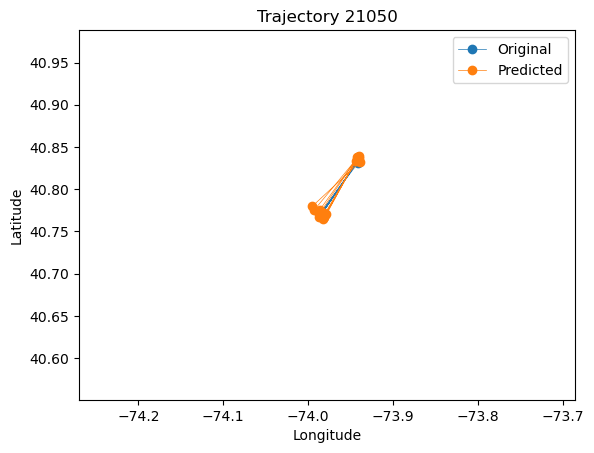

In [19]:
# Use haversine distance to compute the distance between the original and predicted trajectory
from haversine import haversine_vector, Unit
from stg.metrics.measurements import compute_data_preservation

# Change the following line to a constant, if you would like to look at a specific trajectory
tid = random.choice(test_dataset.tids)
visualise.plot_trajectories(
    [test_dataset.originals[tid], predicted[tid]],
    labels=['Original', 'Predicted'],
    title=f"Trajectory {tid}",
    bbox=bbox
)

print(f"Trajectory ID:\t\t{tid}")
CATEGORICAL_FEATURES = ['hour', 'day', 'category']
res = compute_data_preservation(original=test_dataset.originals[tid], generated=predicted[tid], categorical_features=CATEGORICAL_FEATURES, print_results=True)

# Print a table with the absolute and the haversine distance between each two points of the trajectory
original = test_dataset.originals[tid]
generated = predicted[tid]

# combine with column names lat/lon_o and lat/lon_p
combined = pd.concat([original[['lat', 'lon']].reset_index(drop=True).rename(columns={'lat': 'lat_o', 'lon':'lon_o'}),
                      generated[['lat', 'lon']].reset_index(drop=True).rename(columns={'lat': 'lat_p', 'lon':'lon_p'})
                      ], axis=1)
# Compute haversine distance
combined['haversine (m)'] = haversine_vector(combined[['lat_o', 'lon_o']], combined[['lat_p', 'lon_p']], unit=Unit.METERS)
# Compute absolute distance
combined['abs (m)'] = np.linalg.norm(combined[['lat_o', 'lon_o']].to_numpy() - combined[['lat_p', 'lon_p']].to_numpy(), axis=1)
# Print table
print('#' * 80)
print(combined[['lat_o', 'lon_o', 'lat_p', 'lon_p', 'abs (m)', 'haversine (m)']].head())

#### Discussion of Finding:
- The predicted trajectory is very similar to the original one visually.
- The categorical features are nearly identical. Especially the category and day of week are almost always identical. The hour has a bit more variation, but is still very similar. This might be caused by the increased number of values.
- The Euclidean distance of the latitude/longitude vectors is very small, but the mean haversine distance between equivalent locations is still a few hundred meters. This is due to the fact that the Euclidean distance is computed in the projected space, while the haversine distance is computed in the geographic space. A small difference in the lon/lat coordinates results in a large difference in the haversine distance due to the size of the earth. 
- The reason for the apparent "low" accuracy of the location is not only the effect of small changes in Lat/Lon values, but also caused by the fact that the loss for the spatial components is much smaller than the categorical ones. 

In the following, you can see the plot of the same trajectory with the original and predicted locations on the map which allows you to zoom in to have a closer look:

In [20]:
# Plot the example onto a map
SHOW_NUM_FIRST_LOCATIONS = 10  # If you display the entire trajectories, the plot might become too confusing

visualise.plot_traj_folium([test_dataset.originals[tid][:10], predicted[tid][:10]])
# Red is the original trajectory and blue is the predicted one

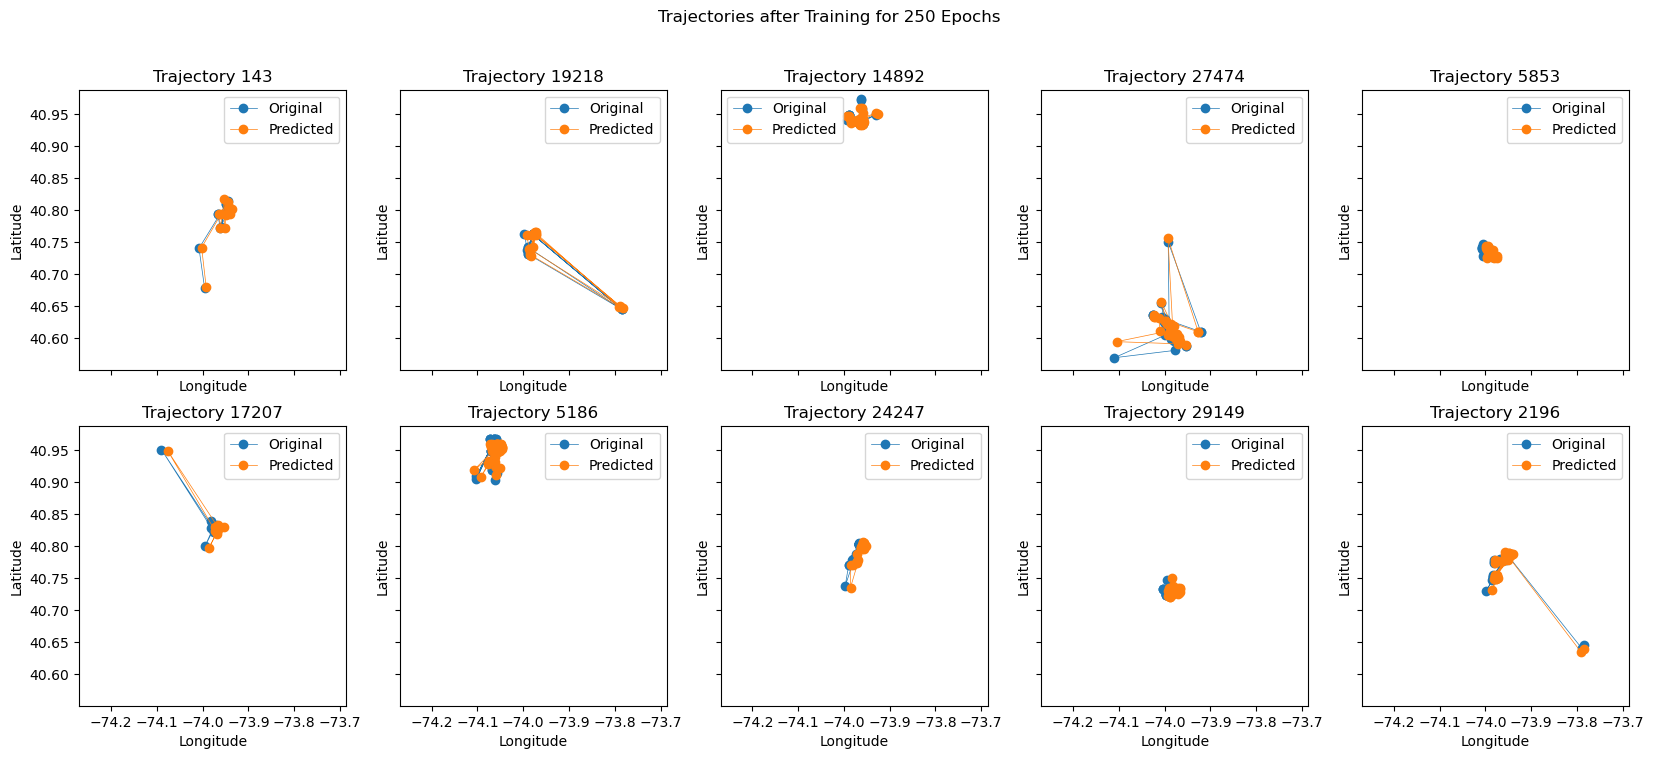

<Figure size 640x480 with 0 Axes>

In [21]:
# Visualize 10 random examples in one plot using visualise.plot_trajectories
tids = random.sample(test_dataset.tids, 10)
fig, ax = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(20, 8))
for i, tid in enumerate(tids):
    visualise.plot_trajectories(
        [test_dataset.originals[tid], predicted[tid]],
        labels=['Original', 'Predicted'],
        title=f"Trajectory {tid}",
        bbox=bbox,
        ax=ax[i // 5, i % 5]
    )
# set Figure title
fig.suptitle(f"Trajectories after Training for {LOAD_EPOCHS} Epochs")
plt.show()
if not RunningInCOLAB:
    plt.savefig(config.BASE_DIR + f'plot/lstm-trajgan-{LOAD_EPOCHS}.png', dpi=300)

One thing that becomes very apparent is that all points are mainly shifted on the map.
However, the general structure of the trajectory is preserved.

In [22]:
# Show the latitude and longitude values of the examples next to each other
left = test_dataset.originals[tid][['lat', 'lon']].reset_index(drop=True)
right = predicted[tid][['lat', 'lon']].reset_index(drop=True)
# Rename Columns
left.rename(columns={'lat': 'lat_original', 'lon': 'lon_original'}, inplace=True)
right.rename(columns={'lat': 'lat_predicted', 'lon': 'lon_predicted'}, inplace=True)
# Add differences
left['lat_diff'] = left['lat_original'] - right['lat_predicted']
left['lon_diff'] = left['lon_original'] - right['lon_predicted']
left['haversine (m)'] = haversine_vector(left[['lat_original', 'lon_original']], right[['lat_predicted', 'lon_predicted']], unit=Unit.METERS)

# Order columns: lat_o, lat_p, lat_d, lon_o, lon_p, lon_d
pd.concat([left, right], axis=1)[['lat_original', 'lat_predicted', 'lat_diff', 'lon_original', 'lon_predicted', 'lon_diff', 'haversine (m)']]

,lat_original,lat_predicted,lat_diff,lon_original,lon_predicted,lon_diff,haversine (m)
0,40.645089,40.639251,0.005839,-73.784523,-73.784943,0.000420,650.211400
1,40.640726,40.634261,0.006465,-73.789372,-73.790415,0.001043,724.186463
2,40.785773,40.791067,-0.005294,-73.950992,-73.957129,0.006137,783.240172
3,40.785773,40.788991,-0.003218,-73.950992,-73.948507,-0.002485,414.446729
4,40.752719,40.753888,-0.001169,-73.983216,-73.979137,-0.004078,367.294593
5,40.779501,40.778341,0.001159,-73.955846,-73.951117,-0.004729,418.526350
6,40.779079,40.781525,-0.002445,-73.954779,-73.950052,-0.004726,481.963592
7,40.785773,40.786616,-0.000843,-73.950992,-73.944678,-0.006314,539.756081
8,40.752719,40.755786,-0.003067,-73.983216,-73.978617,-0.004598,516.060479
9,40.747632,40.748592,-0.000960,-73.986369,-73.981205,-0.005164,447.891286


### Consider entire set of predictions

In the following, we will have a look at the entire test set and compute some statistics.

In [23]:
# Compute mean haversine distance for all trajectories
order = test_dataset.tids
df_original = pd.concat([test_dataset.originals[tid] for tid in order])
df_predicted = pd.concat([predicted[tid] for tid in order])

print(f"---Spatial---")
haversine_distances = haversine_vector(df_original[['lat', 'lon']], df_predicted[['lat', 'lon']], unit=Unit.METERS)
mean_haversine_distance = np.mean(haversine_distances)
print(f"Mean Haversine Distance (per location):\t\t\t{mean_haversine_distance:.1f}m")

# Compute mean euclidean distance for all trajectories
euclidean_distances = np.linalg.norm(df_original[['lat', 'lon']].to_numpy() - df_predicted[['lat', 'lon']].to_numpy(), axis=1)
mean_euclidean_distance = np.mean(euclidean_distances)
print(f"Mean Euclidean Distance (per traj.):\t\t\t{mean_euclidean_distance:.4f}")

# Compute mean number of different categorical features
CATEGORICAL_FEATURES = ['day', 'category', 'hour']
diffs = {feature: 0 for feature in CATEGORICAL_FEATURES}
num_samples = len(test_dataset)
for feature in CATEGORICAL_FEATURES:
    # Create a feature string with the appropriate number of tabs
    feature_str = feature + ':' + '\t' * (2 - int(len(feature) / 8)) 
    diffs[feature] = count_diff_in_list(df_original[feature], df_predicted[feature])
    print(f"---{feature}---")
    print(f"Number of total different {feature_str}\t\t\t{diffs[feature]}")
    print(f"Number of mean (per traj.) different {feature_str}{diffs[feature] / num_samples:.4f}")
    print(f"Percent of wrong predictions for {feature_str}\t{diffs[feature] / len(df_original) * 100:.2f}%")


---Spatial---
Mean Haversine Distance (per location):			785.2m
Mean Euclidean Distance (per traj.):			0.0087
---day---
Number of total different day:					0
Number of mean (per traj.) different day:		0.0000
Percent of wrong predictions for day:			0.00%
---category---
Number of total different category:				8
Number of mean (per traj.) different category:	0.0078
Percent of wrong predictions for category:		0.04%
---hour---
Number of total different hour:					978
Number of mean (per traj.) different hour:		0.9523
Percent of wrong predictions for hour:			4.41%


#### Discussion of Findings

While one can argue that the spatial shift provides some privacy, the categorical features are almost always identical.
In regard to the spatial differences, it can be observed that the structure of the trajectories is preserved, but the locations are shifted.
This is similar to an effect that could be realised through the addition of noise. 
These findings do not show that LSTM-TrajGAN does not protect privacy.
However, it should have become clear that the output trajectories are very close to the original test set.
This raises questions in regard to the provided privacy level, without any theoretical guarantees.


## Evaluation I: Does LSTM-TrajGAN [1] learn the identity function?

We have seen above that LSTM-TrajGAN does lead to different outputs than the input trajectories used during training.
However, the differences are already small.
The question arises whether LSTM-TrajGAN learns the identity function if trained long enough. 
In the paper [1] the training is stopped after 2000 batches (\~250 epochs).
Therefore, we intend to determine how the model performs if trained for much longer.

In [24]:
from stg.models.lstm_trajgan import LSTM_TrajGAN as LSTM_TrajGAN_PyTorch

LOAD_EPOCHS = 1000

torch_gan = LSTM_TrajGAN_PyTorch(
    reference_point=ref,
    scale_factor=sf,
    gpu=0 if USE_TF else GPU, # Have to use 0 in case of TF usage because the device is set up via environment variable for TF,
    learning_rate=lr,
    beta=beta,
)
# Load pretrained model at X epochs
torch_gan.load_parameters(
    epoch=LOAD_EPOCHS,
)

[2024-02-05 11:24:53,622][INFO   ] Loaded parameters from /home/erik/project2/parameters/LSTM_TrajGAN_PT/1000_COM.pth (trajGAN.py:83) 


In [25]:
predicted_df = torch_gan.predict_and_convert(test_dataset, batch_size=batch_size)
predicted = helpers.df2trajectory_dict(predicted_df, 'tid')

In [26]:
# Compute the same dataset statistics as before
order = test_dataset.tids
df_original = pd.concat([test_dataset.originals[tid] for tid in order])
df_predicted = pd.concat([predicted[tid] for tid in order])

print(f"Trajectory ID:\t\t{tid}")
CATEGORICAL_FEATURES = ['hour', 'day', 'category']
res = compute_data_preservation(original=df_original, generated=df_predicted, categorical_features=CATEGORICAL_FEATURES, print_results=True)

Trajectory ID:		2196
Total Points:      	22153
Haversine Distance:	223.52 m
Euclidean Distance:	0.43
hour:              	00 / 22153 (0%)
day:               	00 / 22153 (0%)
category:          	02 / 22153 (0%)


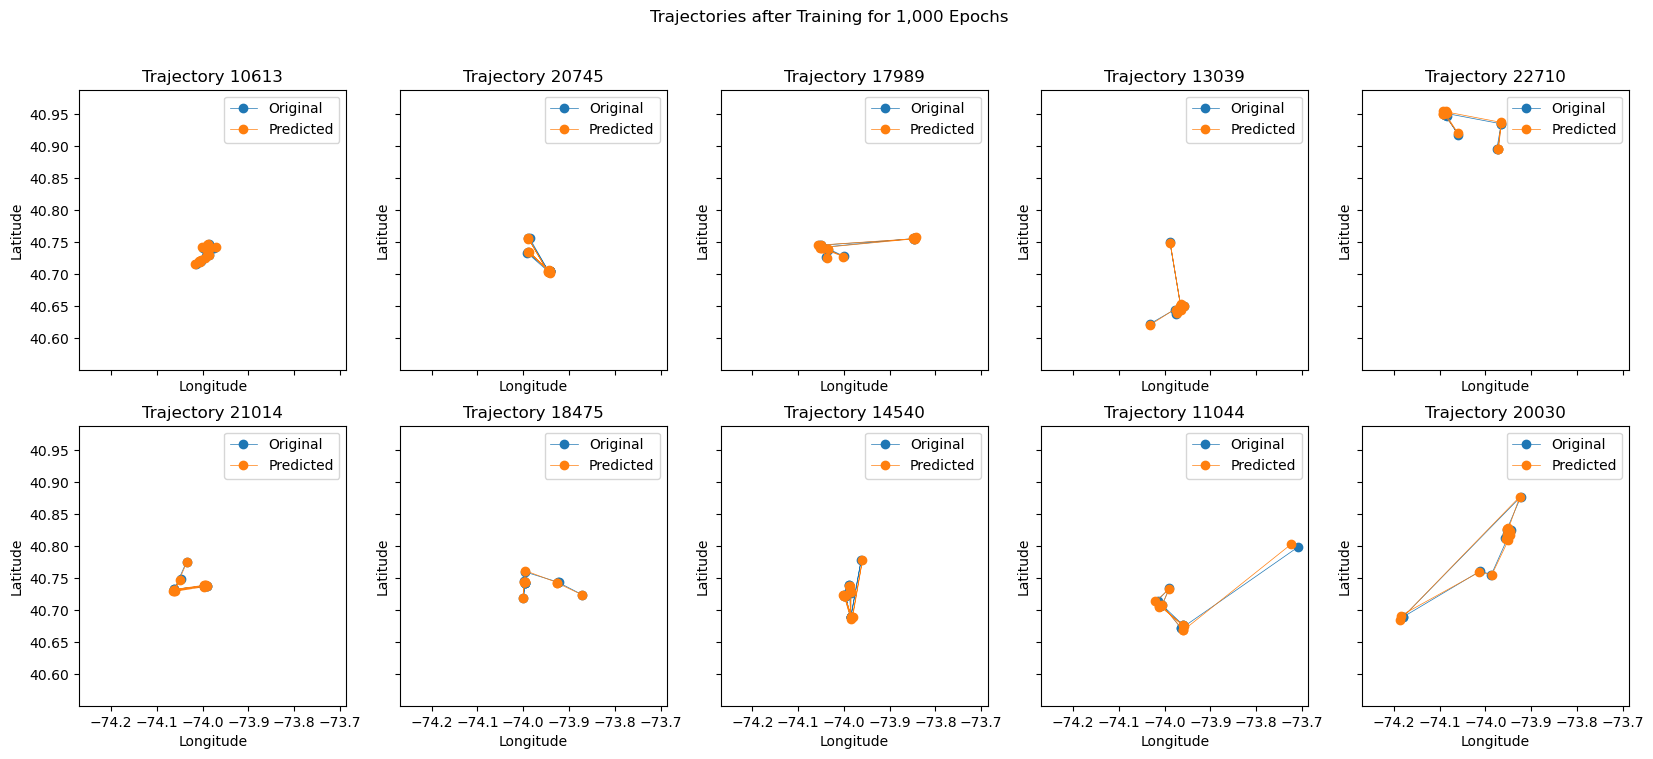

<Figure size 640x480 with 0 Axes>

In [27]:
# Visualize 10 random examples in one plot using visualise.plot_trajectories
tids = random.sample(test_dataset.tids, 10)
fig, ax = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(20, 8))
for i, tid in enumerate(tids):
    sub_ax = ax[i // 5, i % 5]
    visualise.plot_trajectories(
        [test_dataset.originals[tid], predicted[tid]],
        labels=['Original', 'Predicted'],
        title=f"Trajectory {tid}",
        bbox=bbox,
        ax=sub_ax
    )
    
    # Set axis labels (x for bottom row, y for left column) 
    if i // 5 == 1:
        sub_ax.set_xlabel('Longitude')
    if i % 5 == 0:
        sub_ax.set_ylabel('Latitude')
# set Figure title
fig.suptitle(f"Trajectories after Training for {LOAD_EPOCHS:,} Epochs")
plt.show()
if not RunningInCOLAB:
    plt.savefig(config.BASE_DIR + 'plot/lstm-tg-eval-1.png')


In [28]:
# One example on the map
tid = random.choice(test_dataset.tids)  # '19219' is a good example
visualise.plot_traj_folium([test_dataset.originals[tid][:10], predicted[tid][:10]])

# Please note that on some machines, folium might not work properly.

### Discussion

The results show that the longer the model is trained, the closer does the output come to the input. 
In particular, the categorical features are almost always identical.
The spatial differences are still present, but the trajectories are shifted less and less.
Moreover, this effect could be pronounced by increasing the weight of the spatial loss.

Of course, one can argue that the model simply should not be trained to long.
While this is true, and we do not want to argue that LSTM-TrajGAN is not a privacy-preserving model, we want to point out that the model does not provide any theoretical guarantees.
Instead, the privacy that can be provided depends on design decisions such as the number of epochs the model is trained for.
Moreover, these parameters also depend on the dataset.
Accordingly, it is impossible to recommend a set of parameters that provides a certain level of privacy.
If the model is trained for too long, it converges more and more to the identity function having detrimental effects on privacy levels.

### Load Results of 5-fold validation

In [5]:
import pandas as pd
from stg import config


# df = pd.read_csv(config.RESULT_DIR + 'lstm_conv/2023-10-30_20-55-15_fs_2000.csv')  # OLD
df = pd.read_csv(config.RESULT_DIR + 'lstm_conv/2023-11-26_14-42-14_fs_2000.csv')
# print("Foursquare NYC 2'000 Batches")
# df.groupby(['dataset', 'epochs', 'num_batches']).mean()
# print("Foursquare NYC 20'000 Batches")

# Append case for 20'000 batches
df_20k = pd.read_csv(config.RESULT_DIR + 'lstm_conv/2023-11-26_14-55-35_fs_20000.csv')
df = pd.concat([df, df_20k])

# Append case for GeoLife 2'000 batches
df_gl = pd.read_csv(config.RESULT_DIR + 'lstm_conv/2023-11-26_17-09-40_geolife_2000.csv')
df = pd.concat([df, df_gl])

# Append case for GeoLife 20'000 batches
df_gl_20k = pd.read_csv(config.RESULT_DIR + 'lstm_conv/2023-11-26_17-40-45_geolife_20000.csv')
df = pd.concat([df, df_gl_20k])

# Append GeoLife Spatial-Only 2'000 batches
df_gl_spatial = pd.read_csv(config.RESULT_DIR + 'lstm_conv/2023-11-26_21-09-22_geolife_spatial_2000.csv')
df_gl_spatial['dataset'] = 'GeoLife Spatial'
df = pd.concat([df, df_gl_spatial])

# Append GeoLife Spatial-Only 20'000 batches
df_gl_spatial_20k = pd.read_csv(config.RESULT_DIR + 'lstm_conv/2023-11-26_21-33-11_geolife_spatial_20000.csv')
df_gl_spatial_20k['dataset'] = 'GeoLife Spatial'
df = pd.concat([df, df_gl_spatial_20k])

# Rename value 'fs' to 'Foursquare NYC' and geolife by GeoLife
df['dataset'] = df['dataset'].replace('geolife', 'GeoLife')
df['dataset'] = df['dataset'].replace('fs', 'Foursquare NYC')

# res = df.groupby(['dataset', 'epochs', 'num_batches']).mean()
res = df.groupby(['dataset', 'epochs', 'num_batches']).mean().reset_index()

# Print as table
columns = {
    'dataset': 'Dataset',
    'epochs': 'Epochs',
    'num_batches': 'Batches',
    'haversine_mean [m]': 'Haversine Mean [m]',
    'euclidean_mean': 'Euclidean Mean',
    'hour_rel': 'Hour [%]',
    'day_rel': 'Day [%]',
    'category_rel': 'Category [%]',
}
res.rename(columns=columns, inplace=True)
# Drop all other columns
res.drop(columns=[col for col in res.columns if col not in columns.values()], inplace=True)
# Change relative columns to percent
for col in ['Hour [%]', 'Day [%]', 'Category [%]']:
    res[col] = res[col] * 100.0
    # Convert to float
    res[col] = res[col].astype(float)

# Print renamed columns as Markdown table. Round all floating point values to 2 decimal places and use thousands separator and Replace all nan values by N/A
print(res.to_markdown(index=False, floatfmt='.2f', numalign='right').replace('nan', 'N/A'))

# Print to late, bold the first row
# print(res.to_latex(index=False, float_format='%.2f', bold_rows=True, na_rep='N/A'))

| Dataset         |   Epochs |   Batches |   Haversine Mean [m] |   Euclidean Mean |   Hour [%] |   Day [%] |   Category [%] |
|:----------------|---------:|----------:|---------------------:|-----------------:|-----------:|----------:|---------------:|
| Foursquare NYC  |      250 |      2000 |               837.74 |             1.50 |       7.78 |      0.01 |           0.79 |
| Foursquare NYC  |     2500 |     20000 |               182.99 |             0.35 |       0.00 |      0.00 |           0.01 |
| GeoLife         |       11 |      2000 |               492.06 |             8.52 |       3.24 |      0.01 |            N/A |
| GeoLife         |      110 |     20000 |               132.58 |             2.51 |       0.01 |      0.00 |            N/A |
| GeoLife Spatial |       11 |      2000 |               230.02 |             4.12 |        N/A |       N/A |            N/A |
| GeoLife Spatial |      110 |     20000 |                92.28 |             1.57 |        N/A |       N/A |  

| Dataset         |   Epochs |   Batches |   Haversine Mean [m] |   Euclidean Mean |   Hour [%] |   Day [%] |   Category [%] |
|:----------------|---------:|----------:|---------------------:|-----------------:|-----------:|----------:|---------------:|
| Foursquare NYC  |      250 |      2000 |               837.74 |             1.50 |       7.78 |      0.01 |           0.79 |
| Foursquare NYC  |     2500 |     20000 |               182.99 |             0.35 |       0.00 |      0.00 |           0.01 |
| GeoLife         |       11 |      2000 |               492.06 |             8.52 |       3.24 |      0.01 |            N/A |
| GeoLife         |      110 |     20000 |               132.58 |             2.51 |       0.01 |      0.00 |            N/A |
| GeoLife Spatial |       11 |      2000 |               230.02 |             4.12 |        N/A |       N/A |            N/A |
| GeoLife Spatial |      110 |     20000 |                92.28 |             1.57 |        N/A |       N/A |            N/A |

## Evaluation II: Is LSTM-TrajGAN a GAN?

During our evaluation, we noticed that the discriminator loss appeared to only have a small effect on the training.
The original paper evaluated different weights for the loss function, no evaluation was performed without the discriminator loss (and hence without the discriminator altogether).
Therefore, we would like to investigate the effect of the discriminator loss on the training.

The generator's loss is computed as:

    bce_loss * self.p_bce + masked_latlon_mse * self.p_latlon + ce_category_mean * self.p_cat + ce_dow_mean * self.p_dow + ce_hour_mean * self.p_hour
    
Only the first term (`bce_loss`) uses the discriminator's output.
Therefore, we simply set the factor `self.p_bce` to zero, for simplicity, instead of removing the discriminator altogether.
This is the reason why the discriminator loss will be shown in the following.    

### Load Data

In [30]:
from stg.datasets.fs_nyc import FSNYCDataset, SPATIAL_COLUMNS,PATH_ALL

# Compute reference point and scaling factor basd on all data
# Note that this is a privacy leakage in some sense, however, the original implementation does it this way, and we intend to stay as close as possible to the original implementation.
# In theory, it would be preferable to compute the reference point and scaling factor based on the insensitive data only. 
_all = pd.read_csv(PATH_ALL)
ref = helpers.get_ref_point(_all[SPATIAL_COLUMNS])
sf = helpers.get_scaling_factor(_all[SPATIAL_COLUMNS], ref)

# Load Training Dataset
train_dataset = FSNYCDataset(
    mode=DatasetModes.TRAIN,
    latlon_only=False,
    normalize=True,
    return_labels=False,
    reference_point=ref,
    scale_factor=sf,
)

# Load Test Dataset
test_dataset = FSNYCDataset(
    mode=DatasetModes.TEST,
    latlon_only=False,
    normalize=True,
    return_labels=False,
    keep_original=True,
    reference_point=ref,
    scale_factor=sf,
)

print("Training Samples:\t", len(train_dataset))
print("Testing Samples:\t", len(test_dataset))
print("Reference Point:\t", ref)
print("Scaling Factor:\t\t", sf)



# Expected Output:
# Reference Point:	 [-73.977705979516, 40.76959209333479]
# Scaling Factor:    [0.29193802048399675, 0.21873962593050322]

[2024-02-05 11:24:56,395][INFO   ] Reading trajectories from '/home/erik/project2/data/fs_nyc/train_latlon.csv'. (fs_nyc.py:85) 
[2024-02-05 11:24:57,779][INFO   ] Reading trajectories from '/home/erik/project2/data/fs_nyc/test_latlon.csv'. (fs_nyc.py:85) 
Training Samples:	 2052
Testing Samples:	 1027
Reference Point:	 [-73.97770598  40.76959209]
Scaling Factor:		 [0.29193802 0.21873963]


### Create Models

In [31]:
# Create Model
from stg.models.lstm_trajgan import LSTM_TrajGAN as LSTM_TrajGAN_PyTorch
from stg.models.traj_loss import TrajLoss

EPOCHS = 250  # We use the same number of epochs as in the original paper

# Create Baseline Model
gan_baseline = LSTM_TrajGAN_PyTorch(
    reference_point=ref,
    scale_factor=sf,
    gpu=0 if USE_TF else GPU, # Have to use 0 in case of TF usage because the device is set up via environment variable for TF,
    learning_rate=lr,
    beta=beta,
    model_name='LSTM_TrajGAN_PT',
)

# Create Model without Discriminator
gan_without_dis = LSTM_TrajGAN_PyTorch(
    reference_point=ref,
    scale_factor=sf,
    gpu=0 if USE_TF else GPU, # Have to use 0 in case of TF usage because the device is set up via environment variable for TF,
    learning_rate=lr,
    beta=beta,
    model_name='LSTM_TrajGAN_No_Dis',
)
# Overwrite discriminator loss with zero
trajloss_without_dis = TrajLoss(p_bce=0)
gan_without_dis.gen_loss = trajloss_without_dis

# Create Model with Discriminator Loss only
gan_pure = LSTM_TrajGAN_PyTorch(
    reference_point=ref,
    scale_factor=sf,
    gpu=0 if USE_TF else GPU, # Have to use 0 in case of TF usage because the device is set up via environment variable for TF,
    learning_rate=lr,
    beta=beta,
    model_name='LSTM_TrajGAN_Pure',
)
# Set all loss factors to zero except for the discriminator loss
trajloss_pure = TrajLoss(p_bce=1, p_latlon=0, p_cat=0, p_dow=0, p_hour=0)
gan_pure.gen_loss = trajloss_pure

### Training of Discriminator-less Model

In [32]:
# Use saved parameters instead
TRAIN_BASELINE = False
TRAIN_NO_GAN = False
TRAIN_PURE_GAN = False

# Create DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=pad_feature_first
)

if TRAIN_BASELINE:
    # Actual Training
    start = timer()
    gan_baseline.training_loop(
        train_loader,
        epochs=EPOCHS,
        save_freq=50,
        print_training=True,
        notebook=True,
    )
    print(f"Training took:\t\t{timer() - start:.2f}s")
else:
    # Load pretrained model
    gan_baseline.load_parameters(
        epoch=EPOCHS,
    )
if TRAIN_NO_GAN:
    # Actual Training
    start = timer()
    gan_without_dis.training_loop(
        train_loader,
        epochs=EPOCHS,
        save_freq=250,
        print_training=True,
        notebook=True,
    )
    print(f"Training took:\t\t{timer() - start:.2f}s")
else:
    # Load pretrained model
    gan_without_dis.load_parameters(
        epoch=EPOCHS,
    )
if TRAIN_PURE_GAN:
    # Actual Training
    start = timer()
    gan_pure.training_loop(
        train_loader,
        epochs=EPOCHS,
        save_freq=250,
        print_training=True,
        notebook=True,
    )
    print(f"Training took:\t\t{timer() - start:.2f}s")
else:
    # Load pretrained model
    gan_pure.load_parameters(
        epoch=EPOCHS,
    )

[2024-02-05 11:24:58,642][INFO   ] Loaded parameters from /home/erik/project2/parameters/LSTM_TrajGAN_PT/0250_COM.pth (trajGAN.py:83) 
[2024-02-05 11:24:58,649][INFO   ] Loaded parameters from /home/erik/project2/parameters/LSTM_TrajGAN_No_Dis/0250_COM.pth (trajGAN.py:83) 
[2024-02-05 11:24:58,657][INFO   ] Loaded parameters from /home/erik/project2/parameters/LSTM_TrajGAN_Pure/0250_COM.pth (trajGAN.py:83) 


### Predict And Evaluate

In [33]:
# Predict and Convert with Baseline
predicted_df_baseline = gan_baseline.predict_and_convert(test_dataset, batch_size=batch_size)
predicted_baseline = helpers.df2trajectory_dict(predicted_df_baseline, 'tid')

# Predict and Convert without Discriminator
predicted_df_without_dis = gan_without_dis.predict_and_convert(test_dataset, batch_size=batch_size)
predicted_without_dis = helpers.df2trajectory_dict(predicted_df_without_dis, 'tid')

# Predict and Convert with Discriminator Loss only
predicted_df_pure = gan_pure.predict_and_convert(test_dataset, batch_size=batch_size)
predicted_pure = helpers.df2trajectory_dict(predicted_df_pure, 'tid')

In [34]:
# Compute statistics for both models
order = test_dataset.tids
df_original = pd.concat([test_dataset.originals[tid] for tid in order])
df_baseline = pd.concat([predicted_baseline[tid] for tid in order])
df_without_dis = pd.concat([predicted_without_dis[tid] for tid in order])
df_pure = pd.concat([predicted_pure[tid] for tid in order])

haversine_distances_baseline = haversine_vector(df_original[['lat', 'lon']], df_baseline[['lat', 'lon']], unit=Unit.METERS)
mean_haversine_distance_baseline = np.mean(haversine_distances_baseline)

haversine_distances_without_dis = haversine_vector(df_original[['lat', 'lon']], df_without_dis[['lat', 'lon']], unit=Unit.METERS)
mean_haversine_distance_without_dis = np.mean(haversine_distances_without_dis)

haversine_distances_pure = haversine_vector(df_original[['lat', 'lon']], df_pure[['lat', 'lon']], unit=Unit.METERS)
mean_haversine_distance_pure = np.mean(haversine_distances_pure)

# Compute mean euclidean distance for all trajectories
euclidean_distances_baseline = np.linalg.norm(df_original[['lat', 'lon']].to_numpy() - df_baseline[['lat', 'lon']].to_numpy(), axis=1)
mean_euclidean_distance_baseline = np.mean(euclidean_distances_baseline)

euclidean_distances_without_dis = np.linalg.norm(df_original[['lat', 'lon']].to_numpy() - df_without_dis[['lat', 'lon']].to_numpy(), axis=1)
mean_euclidean_distance_without_dis = np.mean(euclidean_distances_without_dis)

euclidean_distances_pure = np.linalg.norm(df_original[['lat', 'lon']].to_numpy() - df_pure[['lat', 'lon']].to_numpy(), axis=1)
mean_euclidean_distance_pure = np.mean(euclidean_distances_pure)

# Compute mean number of different categorical features
CATEGORICAL_FEATURES = ['day', 'category', 'hour']
df_original.rename(columns={'day': 'day'}, inplace=True)
diffs_baseline = {feature: 0 for feature in CATEGORICAL_FEATURES}
diffs_without_dis = {feature: 0 for feature in CATEGORICAL_FEATURES}
diffs_pure = {feature: 0 for feature in CATEGORICAL_FEATURES}
num_samples = len(test_dataset)
for feature in CATEGORICAL_FEATURES:
    # Create a feature string with the appropriate number of tabs
    feature_str = feature + ':' + '\t' * (2 - int(len(feature) / 8)) 
    diffs_baseline[feature] = count_diff_in_list(df_original[feature], df_baseline[feature])
    diffs_without_dis[feature] = count_diff_in_list(df_original[feature], df_without_dis[feature])
    diffs_pure[feature] = count_diff_in_list(df_original[feature], df_pure[feature])
    

# Print results as table
print(f"|\t\t\t\t\tMetric\t\t\t\t\t| Baseline\t| Without Discriminator | Pure Discriminator |")
print(f"| ----------------------------------------- | --------- | --------------------- | ------------------ |")
print(f"| Mean Haversine Distance (per location)\t| {mean_haversine_distance_baseline:.1f}m\t| {mean_haversine_distance_without_dis:.1f}m\t\t\t\t| {mean_haversine_distance_pure:.1f}m\t\t\t |")
print(f"| Mean Euclidean Distance (per location)\t| {mean_euclidean_distance_baseline:.4f}\t| {mean_euclidean_distance_without_dis:.4f}\t\t\t\t| {mean_euclidean_distance_pure:.4f}\t\t\t |")
for feature in CATEGORICAL_FEATURES:
    # Create a feature string with the appropriate number of tabs
    feature_str = feature + '\t' * (2 - int(len(feature) / 8)) 
    print(f"| Number of different {feature_str}\t\t\t| {diffs_baseline[feature]:2}\t\t| {diffs_without_dis[feature]:2}\t\t\t\t\t| {diffs_pure[feature]:2}\t\t\t\t |")
    # print(f"| Number of mean different {feature_str} | {diffs_baseline[feature] / num_samples:.4f} | {diffs_without_dis[feature] / num_samples:.4f} | {diffs_pure[feature] / num_samples:.4f} |")
    print(f"| Percent of wrong {feature_str}\t\t\t\t| {diffs_baseline[feature] / len(df_original) * 100:5.2f}%\t| {diffs_without_dis[feature] / len(df_original) * 100:5.2f}%\t\t\t\t| {diffs_pure[feature] / len(df_original) * 100:5.2f}%\t\t\t |")


# Print table in latex format

|					Metric					| Baseline	| Without Discriminator | Pure Discriminator |
| ----------------------------------------- | --------- | --------------------- | ------------------ |
| Mean Haversine Distance (per location)	| 750.1m	| 1012.7m				| 10037.2m			 |
| Mean Euclidean Distance (per location)	| 0.0082	| 0.0096				| 0.1022			 |
| Number of different day					|  0		|  0					| 19109				 |
| Percent of wrong day						|  0.00%	|  0.00%				| 86.26%			 |
| Number of different category				|  9		|  8					| 18364				 |
| Percent of wrong category					|  0.04%	|  0.04%				| 82.90%			 |
| Number of different hour					| 978		| 163					| 21990				 |
| Percent of wrong hour						|  4.41%	|  0.74%				| 99.26%			 |


### Results

The following table was created during on example run on our machine. 

|					Metric					| Baseline	| Without Discriminator | Pure Discriminator |
| ----------------------------------------- | --------- | --------------------- | ------------------ |
| Mean Haversine Distance (per location)	| 765.4m	| 1014.1m				| 10041.4m			 |
| Mean Euclidean Distance (per location)	| 0.0084	| 0.0097				| 0.1022			 |
| Number of different day					|  0		|  0					| 19109				 |
| Percent of wrong day						|  0.00%	|  0.00%				| 86.26%			 |
| Number of different category				|  9		|  8					| 18364				 |
| Percent of wrong category					|  0.04%	|  0.04%				| 82.90%			 |
| Number of different hour					| 978		| 163					| 21990				 |
| Percent of wrong hour						|  4.41%	|  0.74%				| 99.26%			 |


The results show that the baseline model performs best. 
However, the model without discriminator is only slight worse than the baseline model and even better at predicting the hours.
The model with only the discriminator loss performs worst.
These results indicate that the LSTM-TrajGAN model mainly works as a sequence-to-sequence model and barely uses the discriminator.
The key takeaway here is that the input of original trajectories during generation is essential for model performance and noise alone is not sufficient.
From a privacy perspective, this makes the provisioning of guarantees more challenging as both the training process and the input data require protection.



### Load n-Fold Results

In [7]:
directory = config.RESULT_DIR + 'lstm_gan/'

# FourSquare NYC
df = pd.read_csv(directory + '2023-11-26_16-49-18_fs.csv')
df['dataset'] = 'Foursquare NYC'

# GeoLife
df_gl = pd.read_csv(directory + '2023-11-26_17-28-06_geolife.csv')
df_gl['dataset'] = 'GeoLife'

# GeoLife Spatial
df_gl_spatial = pd.read_csv(directory + '2023-11-26_18-43-19_geolife_spatial.csv')
df_gl_spatial['dataset'] = 'GeoLife Spatial'

# Join both datasets
df = pd.concat([df, df_gl, df_gl_spatial])

# Group by dataset and sort by Dataset ascending followed by loss descending
res = df.groupby(['dataset', 'loss']).mean().reset_index().sort_values(by=['dataset', 'loss'], ascending=[True, False])

columns = {
    'dataset': 'Dataset',
    'loss': 'Loss',
    'haversine_mean [m]': 'Haversine Mean [m]',
    'euclidean_mean': 'Euclidean Mean',
    'hour_rel': 'Hour [%]',
    'day_rel': 'Day [%]',
    'category_rel': 'Category [%]',
}

res.rename(columns=columns, inplace=True)

# Multiply relative columns by 100
for col in ['Hour [%]', 'Day [%]', 'Category [%]']:
    res[col] = res[col] * 100.0
    res[col] = res[col].astype(float)

# Drop all other columns
res.drop(columns=[col for col in res.columns if col not in columns.values()], inplace=True)

# As markdown, align  all values right
print(res.to_markdown(index=False, floatfmt='.2f', tablefmt='github', numalign='right').replace('nan', 'N/A'))

# As latex, align all values right
# print(res.to_latex(index=False, float_format='%.2f', bold_rows=True, na_rep='N/A')) 

| Dataset         | Loss     |   Haversine Mean [m] |   Euclidean Mean |   Hour [%] |   Day [%] |   Category [%] |
|-----------------|----------|----------------------|------------------|------------|-----------|----------------|
| Foursquare NYC  | STD      |               762.65 |             1.35 |       9.05 |      0.02 |           0.78 |
| Foursquare NYC  | NO BCE   |               788.88 |             1.36 |       5.56 |      0.00 |           1.42 |
| Foursquare NYC  | BCE ONLY |             14973.26 |            26.09 |      95.71 |     86.82 |          90.90 |
| GeoLife         | STD      |               451.00 |             7.82 |       2.49 |      0.01 |            N/A |
| GeoLife         | NO BCE   |               440.32 |             7.54 |       2.70 |      0.01 |            N/A |
| GeoLife         | BCE ONLY |              9090.44 |           163.93 |      94.13 |     85.80 |            N/A |
| GeoLife Spatial | STD      |               191.21 |             3.64 |        

| Dataset         | Loss     |   Haversine Mean [m] |   Euclidean Mean |   Hour [%] |   Day [%] |   Category [%] |
|-----------------|----------|----------------------|------------------|------------|-----------|----------------|
| Foursquare NYC  | STD      |               762.65 |             1.35 |       9.05 |      0.02 |           0.78 |
| Foursquare NYC  | NO BCE   |               788.88 |             1.36 |       5.56 |      0.00 |           1.42 |
| Foursquare NYC  | BCE ONLY |             14973.26 |            26.09 |      95.71 |     86.82 |          90.90 |
| GeoLife         | STD      |               451.00 |             7.82 |       2.49 |      0.01 |            N/A |
| GeoLife         | NO BCE   |               440.32 |             7.54 |       2.70 |      0.01 |            N/A |
| GeoLife         | BCE ONLY |              9090.44 |           163.93 |      94.13 |     85.80 |            N/A |
| GeoLife Spatial | STD      |               191.21 |             3.64 |        N/A |       N/A |            N/A |
| GeoLife Spatial | NO BCE   |               276.48 |             4.73 |        N/A |       N/A |            N/A |
| GeoLife Spatial | BCE ONLY |              6403.59 |           126.27 |        N/A |       N/A |            N/A |

## Evaluation III: RAoPT vs. LSTM-TrajGAN

LSTM-TrajGAN is evaluated again trajectory user linking (TUL) in the paper [1].
In the following, we would like to measure the performance of the more recent RAoPT [2] attach against the LSTM-TrajGAN model.

[2]  Erik Buchholz, Alsharif Abuadbba, Shuo Wang, Surya Nepal, and Salil S. Kanhere. 2022. Reconstruction Attack on Differential Private Trajectory Protection Mechanisms. In Annual Computer Security Applications Conference (ACSAC ’22), December 5–9, 2022, Austin, TX, USA. ACM, New York, NY, USA, 14 pages. [https://doi.org/10.1145/3564625.3564628](https://doi.org/10.1145/3564625.3564628)

### 1. Create a train and test set for RAoPT

The RAoPT model requires a train and test set, as it is based on deep learning itself.
As the Foursquare dataset is already quite small, we make use of a simplification here.
We first train LSTM-TrajGAN on the training portion of the dataset. 
Then, we use the trained model to generate two set:
1. A training set for RAoPT: We generate trajectories based on the same dataset LSTM-TrajGAN was trained on
2. A test set for RAoPT: We generate trajectories based on the test set of the original dataset (i.e., trajectories that LSTM-TrajGAN has not seen during training)



In [36]:
EPOCHS = 250  # We use the same number of epochs as in the original paper [1]

# Load datasets
train_dataset = FSNYCDataset(
    mode=DatasetModes.TRAIN,
    latlon_only=False,
    normalize=True,
    return_labels=False,
    reference_point=ref,
    scale_factor=sf,
    keep_original=True,
)
test_dataset = FSNYCDataset(
    mode=DatasetModes.TEST,
    latlon_only=False,
    normalize=True,
    return_labels=False,
    keep_original=True,
    reference_point=ref,
    scale_factor=sf,
)

# Create LSTM-TrajGAN model
gan = LSTM_TrajGAN_PyTorch(
    reference_point=ref,
    scale_factor=sf,
    gpu=0 if USE_TF else GPU, # Have to use 0 in case of TF usage because the device is set up via environment variable for TF,
    learning_rate=lr,
    beta=beta,
    model_name='LSTM_TrajGAN_PT',
)

# Load pretrained model
gan.load_parameters(
    epoch=EPOCHS,
)

# Predict and Convert with training set
predicted_df_train = gan.predict_and_convert(train_dataset, batch_size=batch_size)
predicted_train = helpers.df2trajectory_dict(predicted_df_train, 'tid')

# Predict and Convert test set
predicted_df_test = gan.predict_and_convert(test_dataset, batch_size=batch_size)
predicted_test = helpers.df2trajectory_dict(predicted_df_test, 'tid')

[2024-02-05 11:25:00,785][INFO   ] Reading trajectories from '/home/erik/project2/data/fs_nyc/train_latlon.csv'. (fs_nyc.py:85) 
[2024-02-05 11:25:02,219][INFO   ] Reading trajectories from '/home/erik/project2/data/fs_nyc/test_latlon.csv'. (fs_nyc.py:85) 
[2024-02-05 11:25:02,958][INFO   ] Loaded parameters from /home/erik/project2/parameters/LSTM_TrajGAN_PT/0250_COM.pth (trajGAN.py:83) 


In [37]:
# Save the original & generated datasets for RAoPT
output_dir = config.BASE_DIR + 'data/raopt/'
os.makedirs(output_dir, exist_ok=True)
# Column names required for RAoPT
column_renaming = {
    'lat': 'latitude',
    'lon': 'longitude',
    'label': 'uid',
    'tid': 'trajectory_id',
}
# Store originals
pd.concat(train_dataset.originals.values()).rename(columns=column_renaming).to_csv(output_dir + 'train_orig.csv', index=False)
pd.concat(test_dataset.originals.values()).rename(columns=column_renaming).to_csv(output_dir + 'test_orig.csv', index=False)
# Store predicted
predicted_df_train.rename(columns=column_renaming).to_csv(output_dir + 'train_syn.csv', index=False)
predicted_df_test.rename(columns=column_renaming).to_csv(output_dir + 'test_syn.csv', index=False)

### Run RAoPT training via command line

1. Changes to RAoPT: In the file `train.py` you need to change the following lines:
    - Line 3: `features = ['latlon', 'hour', 'dow']` --> `features = ['latlon']`
    - Lines 84 & 85: `ignore_time=False` --> `ignore_time=True` 
    These changes will ensure that RAoPT only uses the spatial features and ignores the temporal features for simplicity.

2. Training 

        cd RAoPT
        python -m raopt.ml.train ../data/raopt/train_orig.csv ../data/raopt/train_syn.csv model_parameters/parameters.hdf5 144
        
3. Testing

        python -m raopt.ml.predict  -r 40.76 -73.97  -s 0.23 0.30 -e ../data/raopt/test_orig.csv ../data/raopt/test_syn.csv output/lstm_trajgan250.csv model_parameters/parameters.hdf5 144


#### Results

Here are the results we obtained during our evaluation:

Average Euclidean Distance protected		<-->	original:	676.7193436033974
Average Euclidean Distance reconstructed	<-->	original:	447.9047631741993
Improvement by 32.1%.
Average Hausdorff Distance protected		<-->	original:	1292.9240904227368
Average Hausdorff Distance reconstructed	<-->	original:	963.6540932216253
Improvement by 24.1%.
Average Jaccard Distance protected		    <-->	original:	0.6034057338022244
Average Jaccard Distance reconstructed		<-->	original:	0.7116564335126819
Improvement by 17.9%.

While the attack can reduce the distances significantly less than for the traditional protection schemes used in the RAoPT paper [2], it shows that the attack can still remove of the obfuscation infused by LSTM-TrajGAN.
Based on the previous results, we assume that this could be based on the shift we observed in the trajectories.

### Alternative: Run RAoPT within the notebook

In [38]:
# Tensorflow Header
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPU}"
# noinspection PyUnresolvedReferences
import tensorflow as tf

# import RAoPT encoder and AttackModel
# Requires adding the RAoPT directory to the PYTHONPATH
import sys
sys.path.append(config.BASE_DIR + 'RAoPT')
# noinspection PyUnresolvedReferences
from raopt.ml.model import AttackModel as RAoPT
# noinspection PyUnresolvedReferences
from raopt.ml import encoder
# noinspection PyUnresolvedReferences
from raopt.utils import helpers as raopt_helpers

Using GPU 0!


In [39]:
# Load datasets in correct format
originals = raopt_helpers.read_trajectories_from_csv(output_dir + 'train_orig.csv')
protected = raopt_helpers.read_trajectories_from_csv(output_dir + 'train_syn.csv')

# Encode
encoded_originals = encoder.encode_trajectory_dict(originals, ignore_time=False)
encoded_protected = encoder.encode_trajectory_dict(protected, ignore_time=False)
keys = list(encoded_protected.keys())
trainX = [encoded_protected[i] for i in keys]
trainY = [encoded_originals[i] for i in keys]

[2024-02-05 11:25:05,473][INFO   ] Reading Trajectories from /home/erik/project2/data/raopt/train_orig.csv. (helpers.py:279) 
[2024-02-05 11:25:05,607][INFO   ] Reading Trajectories from /home/erik/project2/data/raopt/train_syn.csv. (helpers.py:279) 
[2024-02-05 11:25:06,033][INFO   ] Encoding trajectories... (encoder.py:148) 
[2024-02-05 11:25:08,039][INFO   ] Encoded trajectories in 2s. (encoder.py:160) 
[2024-02-05 11:25:08,044][INFO   ] Encoding trajectories... (encoder.py:148) 
[2024-02-05 11:25:10,099][INFO   ] Encoded trajectories in 2s. (encoder.py:160) 


In [40]:
# Create and train model
raopt = RAoPT(
        max_length=max_len,
        features=['latlon'],
        scale_factor=sf,
        reference_point=ref,
        parameter_file=config.BASE_DIR + 'parameters/RAoPT/parameters.hdf5',
)

In [41]:
# Train model  -> Too expensive for notebook
# h = raopt.train(
#     trainX,
#     trainY,
#     use_val_loss=True
# )
# 
# log.info(f"Training Completed After {len(h.history['loss'])} Epochs.")

### Eval Results

In [8]:
# Print Results from file
RESULT_DIR = config.RESULT_DIR + 'raopt_vs_lstm/'

# Add RAoPT to path
sys.path.append(config.BASE_DIR + 'RAoPT')
# noinspection PyUnresolvedReferences
from raopt.eval.main import comp_results, print_results_detailed

# Files
file_geolife_spatial = RESULT_DIR + '2023-11-26_21-09-26_geolife_512.csv'
file_geolife = RESULT_DIR + '2023-11-26_17-01-56_geolife_512.csv'
file_fs_128 = RESULT_DIR + '2023-11-26_15-45-46_fs_128.csv'

# dict Name: filename
files = {
    'GeoLife Spatial': file_geolife_spatial,
    'GeoLife': file_geolife,
    'Foursquare NYC (BS = 128)': file_fs_128,
}

In [9]:
for file in files:
    num_hash = 98 - len(file)
    print('#' * (num_hash // 2), file, f"{'#' * (num_hash // 2)}{'#' * (num_hash % 2)}")
    print_results_detailed(pd.read_csv(files[file]))
    print("#"*100)
    

######################################### GeoLife Spatial ##########################################
Average Euclidean Distance protected		<-->	original:	306.95150463447624
Average Euclidean Distance reconstructed	<-->	original:	136.51272118528564
Improvement by 33.4%.
Average Hausdorff Distance protected		<-->	original:	496.88624226759356
Average Hausdorff Distance reconstructed	<-->	original:	197.69120371094255
Improvement by 50.2%.
Average Jaccard Distance protected		<-->	original:	0.16452645335670654
Average Jaccard Distance reconstructed		<-->	original:	0.26408941255383434
Improvement by 60.5%.
####################################################################################################
############################################# GeoLife ##############################################
Average Euclidean Distance protected		<-->	original:	303.74215656239386
Average Euclidean Distance reconstructed	<-->	original:	142.52718880364188
Improvement by 34.9%.
Average Hausdorff Dist

In [10]:
# As table
results = {
    'Dataset': [],
    'Euclidean Improvement [%]': [],
    'Hausdorff Improvement [%]': [], 
    'Jaccard Improvement [%]': []
}
for dataset in files:
    df = pd.read_csv(files[dataset])
    e_imp, h_imp, jaccard_before, jaccard_after = comp_results(df)
    results['Dataset'].append(dataset)
    results['Euclidean Improvement [%]'].append(e_imp)
    results['Hausdorff Improvement [%]'].append(h_imp)
    j_imp = 100 * (jaccard_after - jaccard_before) / abs(jaccard_before)
    results['Jaccard Improvement [%]'].append(j_imp)
    
results = pd.DataFrame(results)

# Print as Markdown table, round 2 to 2 digits and append % to all values
print(results.to_markdown(index=False, floatfmt='.2f'))

| Dataset                   |   Euclidean Improvement [%] |   Hausdorff Improvement [%] |   Jaccard Improvement [%] |
|:--------------------------|----------------------------:|----------------------------:|--------------------------:|
| GeoLife Spatial           |                       33.40 |                       50.15 |                     60.51 |
| GeoLife                   |                       34.95 |                       45.57 |                     69.15 |
| Foursquare NYC (BS = 128) |                       24.94 |                       19.81 |                     14.30 |


| Dataset                   |   Euclidean Improvement [%] |   Hausdorff Improvement [%] |   Jaccard Improvement [%] |
|:--------------------------|----------------------------:|----------------------------:|--------------------------:|
| GeoLife Spatial           |                       33.40 |                       50.15 |                     60.51 |
| GeoLife                   |                       34.95 |                       45.57 |                     69.15 |
| Foursquare NYC (BS = 128) |                       24.94 |                       19.81 |                     14.30 |


In [11]:
results['Dataset'][2] = 'Foursquare NYC'

# Print as LaTeX table
print(results.to_latex(index=False, float_format="%.2f", column_format='lccc'))

\begin{tabular}{lccc}
\toprule
        Dataset &  Euclidean Improvement [\%] &  Hausdorff Improvement [\%] &  Jaccard Improvement [\%] \\
\midrule
GeoLife Spatial &                      33.40 &                      50.15 &                    60.51 \\
        GeoLife &                      34.95 &                      45.57 &                    69.15 \\
 Foursquare NYC &                      24.94 &                      19.81 &                    14.30 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_119787/3991108702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Dataset'][2] = 'Foursquare NYC'
/tmp/ipykernel_119787/3991108702.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False, float_format="%.2f", column_format='lccc'))
